In [ ]:
!pip install librosa tensorflow scikit-learn noisereduce resampy pydub
!apt-get install ffmpeg

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.


In [ ]:
import os
import librosa
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pickle
import noisereduce as nr

In [ ]:
categories = ["ileri", "geri", "sag", "sol", "dur"]
X, y = [], []

In [ ]:
!pip install --upgrade librosa resampy


In [ ]:
# Gerekli kütüphaneler içe aktarılıyor
import librosa                     # Ses sinyali işleme için
import librosa.display             # Librosa ile görselleştirme için
import numpy as np                 # Sayısal işlemler için
import os                          # Dosya ve klasör işlemleri için
import noisereduce as nr           # Gürültü azaltma için
import soundfile as sf             # Ses dosyalarını okuma/yazma işlemleri için
from tqdm import tqdm              # İlerleme çubuğu için
import random                      # Rastgele işlemler için
import re                          # Düzenli ifadeler için
import resampy                     # Yeniden örnekleme için

print("Librosa başarıyla yüklendi!")

# Özellik çıkarımı yapan fonksiyon tanımlanıyor
def extract_features(file_path, max_pad_len=100):
    """
    Belirtilen ses dosyasından MFCC (Mel Frekans Kepstrum Katsayıları) ve Mel Spectrogram çıkarır.
    Aynı zamanda gürültü azaltma ve normalizasyon uygular.

    """
    try:
        # Ses dosyası yükleniyor
        audio, sample_rate = librosa.load(file_path, res_type='kaiser_fast')

        # Gürültü azaltma uygulanıyor
        audio = nr.reduce_noise(y=audio, sr=sample_rate)

        # Sessiz kısımlar kırpılıyor
        audio, _ = librosa.effects.trim(audio, top_db=20)

        # Ses normalizasyonu yapılıyor (değerler -1 ile 1 arasında ölçekleniyor)
        audio = librosa.util.normalize(audio)

        # MFCC özellikleri çıkarılıyor (40 katsayı)
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)

        # Mel spektrogramı hesaplanıyor
        mel_spec = librosa.feature.melspectrogram(y=audio, sr=sample_rate)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)  # dB'ye dönüştürme

        # MFCC'yi sabit boyuta getirmek için padding (doldurma) işlemi
        pad_width = max_pad_len - mfccs.shape[1]
        if pad_width > 0:
            mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
        else:
            mfccs = mfccs[:, :max_pad_len]

        return mfccs, mel_spec_db, audio, sample_rate

    except Exception as e:
        print(f"\U0001F6A8 Hata! Dosya işlenemedi: {file_path} - {e}")
        return None, None, None, None

# Veri seti klasör yolları belirleniyor
data_root = "/content/drive/MyDrive/wav_1/"                # Ham ses verilerinin bulunduğu klasör
processed_root = "/content/drive/MyDrive/islenmis_ses/"    # İşlenmiş seslerin kaydedileceği klasör
os.makedirs(processed_root, exist_ok=True)                 # Klasör yoksa oluşturuluyor

# İşlenecek dosyaları tutmak için listeler
processed_files = []  # İşlenmiş dosyaların bilgilerini tutar
wav_files = []        # Tüm .wav dosyalarının yol ve kategori bilgilerini tutar

# Veri klasörü gezilerek her bir kategorideki .wav dosyaları toplanıyor
for category in os.listdir(data_root):
    category_path = os.path.join(data_root, category)
    if os.path.isdir(category_path):
        # Kategorinin işlenmiş dosyalarının gideceği klasör oluşturuluyor
        output_folder = os.path.join(processed_root, category)
        os.makedirs(output_folder, exist_ok=True)

        for file in os.listdir(category_path):
            if file.endswith(".wav"):
                file_path = os.path.join(category_path, file)
                wav_files.append((file_path, category, file))

# Dosyalar sırayla işleniyor
for file_path, category, file_name in tqdm(wav_files, desc="Ses Dosyaları İşleniyor", unit="dosya"):
    mfccs, mel_spec_db, audio, sample_rate = extract_features(file_path)
    if mfccs is not None:
        # Gürültüsü azaltılmış ses dosyası yeni klasöre yazılıyor
        output_wav_path = os.path.join(processed_root, category, file_name)
        sf.write(output_wav_path, audio, sample_rate)

        # İşlenmiş dosya bilgisi kaydediliyor
        processed_files.append((file_path, category, mfccs, mel_spec_db, audio, sample_rate, output_wav_path))

# Toplam işlenen dosya sayısı yazdırılıyor
print(f"\n✅ İşlenen Toplam Dosya Sayısı: {len(processed_files)}")


Librosa başarıyla yüklendi!


Ses Dosyaları İşleniyor: 100%|██████████| 3612/3612 [08:33<00:00,  7.03dosya/s]


✅ İşlenen Toplam Dosya Sayısı: 3612



🎵 **[1] Seçilen dosya: /content/drive/MyDrive/wav_1/dur/634.wav**
📂 Kategori: dur 


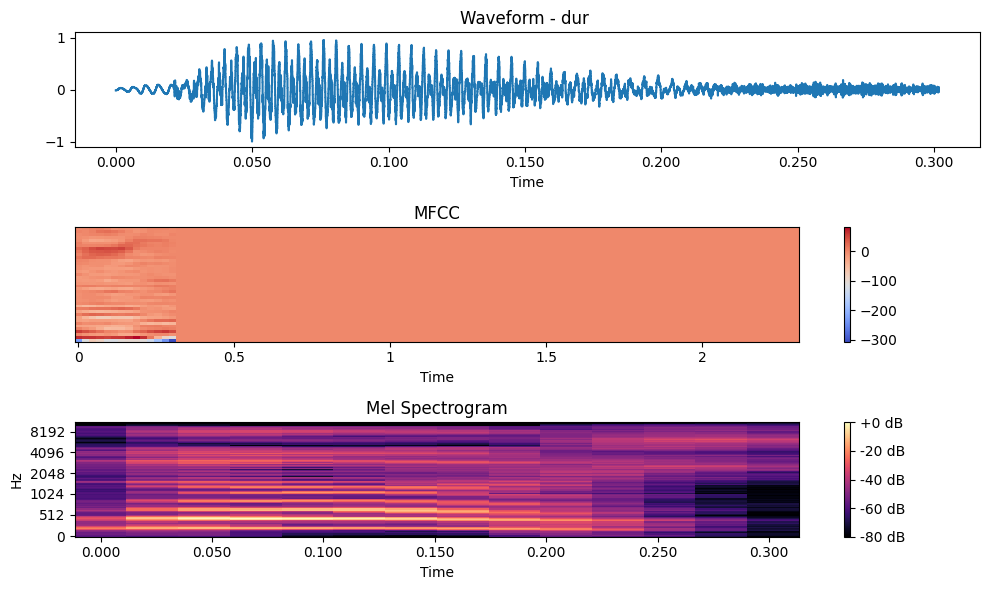


🎵 **[2] Seçilen dosya: /content/drive/MyDrive/wav_1/dur/665.wav**
📂 Kategori: dur 


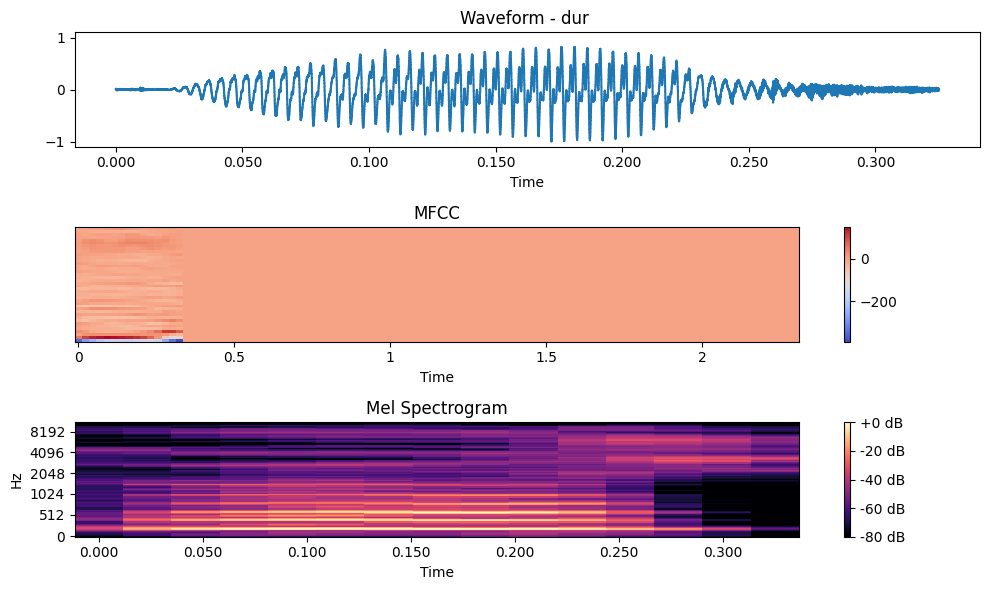


🎵 **[3] Seçilen dosya: /content/drive/MyDrive/wav_1/dur/724.wav**
📂 Kategori: dur 


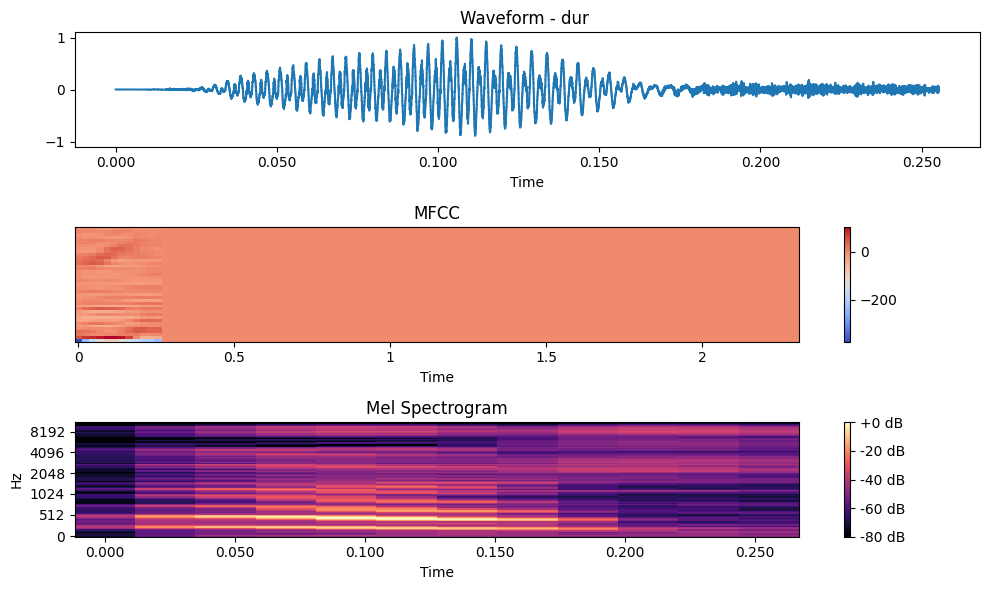

In [ ]:
import random  # Rastgele seçim yapmak için
import matplotlib.pyplot as plt  # Grafik çizimi için
import librosa.display  # Librosa'nın ses gösterim araçları
import IPython.display as ipd  # Jupyter ortamında ses çalmak için

if processed_files:
    # İşlenmiş dosyalardan maksimum 3 tanesini rastgele seçiyoruz
    random_files = random.sample(processed_files, min(3, len(processed_files)))

    # Seçilen her bir dosya için işlem yap
    for idx, (file_path, category, mfccs, mel_spec_db, audio, sr, output_path) in enumerate(random_files):
        print(f"\n🎵 **[{idx+1}] Seçilen dosya: {file_path}**")
        print(f"📂 Kategori: {category} ")

        plt.figure(figsize=(10, 6))  # Grafik boyutu

        # 1️⃣ Waveform (Ses dalga formu)
        plt.subplot(3, 1, 1)  # 3 satır, 1 sütunluk çizim, 1. grafik
        librosa.display.waveshow(audio, sr=sr)  # Ses dalga formunu çiz
        plt.title(f"Waveform - {category} ")  # Başlık

        # 2️⃣ MFCC (Mel Frekans Kepstral Katsayıları)
        plt.subplot(3, 1, 2)  # 2. grafik
        librosa.display.specshow(mfccs, sr=sr, x_axis='time')  # MFCC'yi göster
        plt.colorbar()  # Renk çubuğu ekle
        plt.title("MFCC")  # Başlık

        # 3️⃣ Mel Spectrogram (Mel Ölçekli Güç Spektrumu)
        plt.subplot(3, 1, 3)  # 3. grafik
        librosa.display.specshow(mel_spec_db, sr=sr, x_axis='time', y_axis='mel')  # Mel spectrogram çizimi
        plt.colorbar(format='%+2.0f dB')  # dB cinsinden renk çubuğu
        plt.title("Mel Spectrogram")  # Başlık

        plt.tight_layout()  # Tüm alt grafiklerin düzenli görünmesini sağlar
        plt.show()  # Grafik göster

        # 🎧 Seçilen sesi oynat
        display(ipd.Audio(output_path))  # IPython arayüzünde ses çalar

else:
    # Eğer işlenmiş dosya yoksa kullanıcıya bilgi ver
    print("🚨 İşlenmiş dosya bulunamadı!")


In [ ]:
import os
import random
import IPython.display as ipd

# İşlenmiş seslerin bulunduğu ana klasör
processed_root = "/content/drive/MyDrive/islenmis_ses/"

# Her klasörden bir örnek dosya seçip oynat
sample_files = {}

for class_folder in os.listdir(processed_root):
    class_path = os.path.join(processed_root, class_folder)

    if os.path.isdir(class_path):  # Sadece klasörleri kontrol et
        files = [f for f in os.listdir(class_path) if f.endswith(".wav")]

        if files:  # Eğer klasörde dosya varsa rastgele seç
            sample_file = random.choice(files)
            sample_files[class_folder] = os.path.join(class_path, sample_file)

# Seçilen sesleri oynat
for class_name, file_path in sample_files.items():
    print(f"🔊 **{class_name}** komutundan örnek ses:")
    display(ipd.Audio(file_path))


🔊 **ileri** komutundan örnek ses:


🔊 **sol** komutundan örnek ses:


🔊 **sag** komutundan örnek ses:


🔊 **dur** komutundan örnek ses:


🔊 **geri** komutundan örnek ses:


In [ ]:
print("\n📋 **Tüm İşlenen Dosyalar:**")
for idx, (file_path, category, _, _, _, _, output_wav_path) in enumerate(processed_files):
    print(f"[{idx+1}] 📂 Kategori: {category} | 📄 Dosya: {output_wav_path}")


📋 **Tüm İşlenen Dosyalar:**
[1] 📂 Kategori: geri | 📄 Dosya: /content/drive/MyDrive/islenmis_ses/geri/71_original.wav
[2] 📂 Kategori: geri | 📄 Dosya: /content/drive/MyDrive/islenmis_ses/geri/711.wav
[3] 📂 Kategori: geri | 📄 Dosya: /content/drive/MyDrive/islenmis_ses/geri/712.wav
[4] 📂 Kategori: geri | 📄 Dosya: /content/drive/MyDrive/islenmis_ses/geri/713.wav
[5] 📂 Kategori: geri | 📄 Dosya: /content/drive/MyDrive/islenmis_ses/geri/714.wav
[6] 📂 Kategori: geri | 📄 Dosya: /content/drive/MyDrive/islenmis_ses/geri/715.wav
[7] 📂 Kategori: geri | 📄 Dosya: /content/drive/MyDrive/islenmis_ses/geri/70_original.wav
[8] 📂 Kategori: geri | 📄 Dosya: /content/drive/MyDrive/islenmis_ses/geri/701.wav
[9] 📂 Kategori: geri | 📄 Dosya: /content/drive/MyDrive/islenmis_ses/geri/702.wav
[10] 📂 Kategori: geri | 📄 Dosya: /content/drive/MyDrive/islenmis_ses/geri/703.wav
[11] 📂 Kategori: geri | 📄 Dosya: /content/drive/MyDrive/islenmis_ses/geri/704.wav
[12] 📂 Kategori: geri | 📄 Dosya: /content/drive/MyDrive/islenm

In [ ]:
import numpy as np
import os
import pickle

# 📂 İşlenmiş verinin bulunduğu ana klasör
processed_audio = "/content/drive/MyDrive/islenmis_ses/"

# 📈 Veri listeleri (Eğitim verisi için)
X = []  # MFCC özellikleri
y = []  # Komut etiketleri

# 📊 Komut etiketleri
label_mapping = {
    "geri": 0,   # Binary: 100
    "sag": 1,    # Binary: 001
    "dur": 2,    # Binary: 000
    "sol": 3,    # Binary: 010
    "ileri": 4   # Binary: 111
}

# 🔄 Veri yükleme döngüsü
for category in os.listdir(processed_audio):
    category_path = os.path.join(processed_audio, category)

    if os.path.isdir(category_path) and category in label_mapping:
        print(f"📂 Komut: {category} yükleniyor...")

        for file_name in os.listdir(category_path):
            if file_name.endswith(".wav"):
                file_path = os.path.join(category_path, file_name)

                # MFCC özellikleri çıkar
                mfcc_features, _, _, _ = extract_features(file_path)
                if mfcc_features is None:
                    print(f"⚠️ MFCC çıkartılamadı: {file_path}")
                    continue

                X.append(mfcc_features)
                y.append(label_mapping[category])

# 👌 Tamamlama mesajı
print(f"✅ Veri yükleme işlemi tamamlandı! Toplam işlem yapılan dosya sayısı: {len(X)}")


📂 Komut: ileri yükleniyor...
📂 Komut: sol yükleniyor...
📂 Komut: sag yükleniyor...
📂 Komut: dur yükleniyor...
📂 Komut: geri yükleniyor...
✅ Veri yükleme işlemi tamamlandı! Toplam işlem yapılan dosya sayısı: 3612


In [ ]:
import numpy as np

# Veriyi NumPy dosyası olarak kaydet
X_array = np.array(X)
y_array = np.array(y)

# Kaydedilecek dosya yolları
X_file_path = "/content/drive/MyDrive/islenmis_X.npy"
y_file_path = "/content/drive/MyDrive/islenmis_y.npy"

# Veriyi kaydet
np.save(X_file_path, X_array)
np.save(y_file_path, y_array)

print(f"✅ Veriler başarıyla kaydedildi:\nX: {X_file_path}\ny: {y_file_path}")


✅ Veriler başarıyla kaydedildi:
X: /content/drive/MyDrive/islenmis_X.npy
y: /content/drive/MyDrive/islenmis_y.npy


In [ ]:
import numpy as np

# Kaydedilen dosya yolları
X_file_path = "/content/drive/MyDrive/islenmis_X.npy"
y_file_path = "/content/drive/MyDrive/islenmis_y.npy"

# Veriyi geri yükle
X_loaded = np.load(X_file_path)
y_loaded = np.load(y_file_path)

# Geri yüklenen verilerin boyutlarını kontrol et
print(f"✅ X verisi yüklendi: {X_loaded.shape}")
print(f"✅ y verisi yüklendi: {y_loaded.shape}")


✅ X verisi yüklendi: (3612, 40, 100)
✅ y verisi yüklendi: (3612,)


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam

# Veriyi yükle
X = np.load('/content/drive/MyDrive/islenmis_X.npy')
y = np.load('/content/drive/MyDrive/islenmis_y.npy')

In [ ]:
# Veri kümesini eğitim ve test olarak ayır
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Modeli sıralı (katman katman) bir yapıda tanımla
model = Sequential()
# Giriş verisini 2D matristen 1D vektöre dönüştür (örneğin: (40, 100) → 4000)
model.add(Flatten(input_shape=(X_train.shape[1], X_train.shape[2])))
# 512 nöronlu ilk tam bağlı katman (ReLU aktivasyonu ile)
model.add(Dense(512, input_shape=(X_train.shape[1],), activation='relu'))
# Aşırı öğrenmeyi (overfitting) önlemek için %50 dropout (rastgele nöronları geçici olarak devre dışı bırakır)
model.add(Dropout(0.5))
# 256 nöronlu ikinci gizli katman (ReLU aktivasyonu ile)
model.add(Dense(256, activation='relu'))
#Tekrar %50 dropout uygula
model.add(Dropout(0.5))
#  128 nöronlu üçüncü gizli katman
model.add(Dense(128, activation='relu'))
# Çıkış katmanı:
#    - Sınıf sayısı kadar nöron içerir (örneğin 5 komut: ileri, geri, sağ, sol, dur)
#    - Softmax aktivasyonu: her sınıf için olasılık verir
model.add(Dense(len(np.unique(y)), activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Modeli eğit
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.4972 - loss: 22.4122 - val_accuracy: 0.8243 - val_loss: 1.5517
Epoch 2/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.7381 - loss: 3.8303 - val_accuracy: 0.8700 - val_loss: 1.0846
Epoch 3/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.8304 - loss: 1.9561 - val_accuracy: 0.9405 - val_loss: 0.9923
Epoch 4/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.8425 - loss: 1.4244 - val_accuracy: 0.9419 - val_loss: 0.5114
Epoch 5/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.8540 - loss: 1.4426 - val_accuracy: 0.9336 - val_loss: 0.6137
Epoch 6/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.8797 - loss: 1.0160 - val_accuracy: 0.9544 - val_loss: 0.3271
Epoch 7/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.8888 - loss: 0.7985 - val_accuracy: 0.9419 - val_loss: 1.0540
Epoch 8/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.8867 - loss: 1.0605 - val_accuracy: 0.9474 - 

In [ ]:
# Modeli kaydet
model.save('/content/drive/MyDrive/komut.h5')
print("✅ Komut tanıma modeli başarıyla kaydedildi.")

✅ Komut tanıma modeli başarıyla kaydedildi.


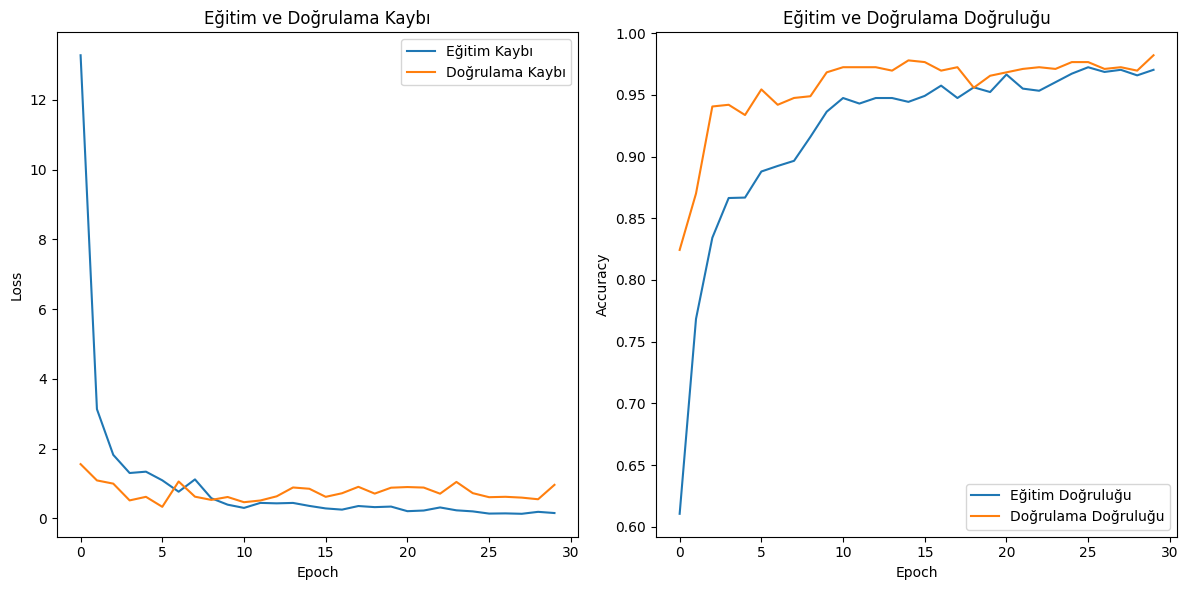

In [ ]:
# Eğitim doğruluğu ve kaybını görselleştir
def plot_training_history(history):
    # Eğitim kaybı ve doğruluğu grafikleri
    plt.figure(figsize=(12, 6))

    # Kaybı (loss) çiz
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Eğitim Kaybı')
    plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
    plt.title('Eğitim ve Doğrulama Kaybı')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Doğruluğu (accuracy) çiz
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
    plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
    plt.title('Eğitim ve Doğrulama Doğruluğu')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Grafik göster
    plt.tight_layout()
    plt.show()

# Eğitim sonuçlarını görselleştir
plot_training_history(history)

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


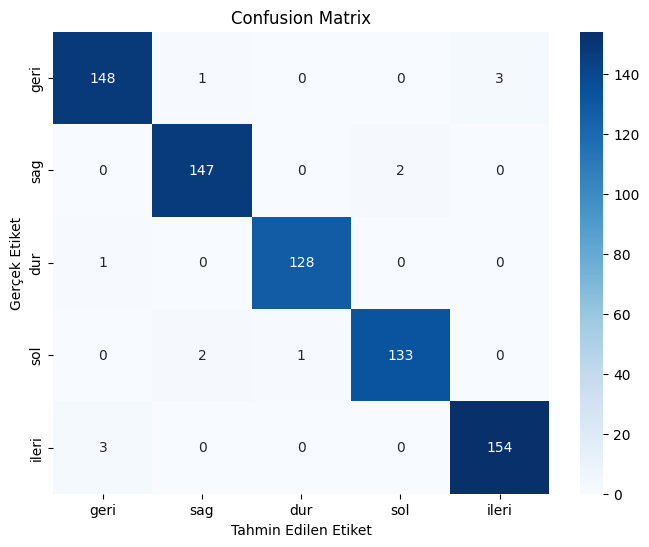

Sınıflandırma Raporu:
              precision    recall  f1-score   support

        geri       0.97      0.97      0.97       152
         sag       0.98      0.99      0.98       149
         dur       0.99      0.99      0.99       129
         sol       0.99      0.98      0.98       136
       ileri       0.98      0.98      0.98       157

    accuracy                           0.98       723
   macro avg       0.98      0.98      0.98       723
weighted avg       0.98      0.98      0.98       723


Label Mapping:
geri: 0
sag: 1
dur: 2
sol: 3
ileri: 4


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Modeli test verisiyle tahmin et
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # En yüksek olasılığa sahip sınıfı seç

# Gerçek etiketler
y_true = y_test  # Eğer y_test zaten tek boyutluysa, np.argmax gerekmez

# Confusion Matrix (Karışıklık Matrisi) oluştur
cm = confusion_matrix(y_true, y_pred_classes)

# Confusion Matrix'i görselleştir
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=list(label_mapping.keys()), yticklabels=list(label_mapping.keys()))
plt.title("Confusion Matrix")
plt.xlabel("Tahmin Edilen Etiket")
plt.ylabel("Gerçek Etiket")
plt.show()

# Classification Report (Sınıflandırma Raporu)
report = classification_report(y_true, y_pred_classes, target_names=list(label_mapping.keys()))
print("Sınıflandırma Raporu:")
print(report)

# label_mapping'i yazdır
print("\nLabel Mapping:")
for command, label in label_mapping.items():
    print(f"{command}: {label}")


In [ ]:
!pip install sounddevice